# Eccentric Search Prospects for Cosmic Explorer

## Amber Lenon<sup>1</sup>, Alexander Nitz<sup>2,3</sup>, Duncan Brown<sup>1</sup>

**<sup>1</sup> Department of Physics, Syracuse University, Syracuse NY 13224, USA** <br />
**<sup>2</sup> Max-Planck-Institut für Gravitationsphysik, Albert-Einstein-Institut, D-30167 Hannover, Germany** <br />
**<sup>3</sup> Leibniz Universität Hannover, D-30167 Hannover, Germany**

We want to see explore how sensitive a non-eccentric search will be for eccentric searches in third generation detectors, specifically Cosmic Explorer (referenced as CE). Cosmic Explorer will be more sensitive with arms longer 10x longer than that of LIGO. Currently for LIGO circular searches are effective for eccentricities below 0.05, but that might not be the case for Cosmic Explorer. To evaluate the sensitivity, we generate a circular template bank at a frequency of 7Hz and compare that to an eccentric template with a randomly generated mass1, mass2, and eccentricity. 

### Set Imports and plot format

In [30]:
#PyCBC imports
import pycbc
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import match
from pycbc.types import FrequencySeries
from pycbc import distributions
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match, sigmasq
import pycbc.conversions as conversions

#python imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import argparse
import sys, os
import pandas as pd

#Set seed for random number generator
np.random.seed(seed=None)

rcParams['figure.figsize']=(14,8)
rcParams['axes.grid']=True
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

### Set data segment length for analysis

In [10]:
td_length = 2048 # seconds
srate = 4096 # Hz
N = int(td_length * srate)
fd_length = int(N / 2 + 1)
delta_t = 1.0 / srate
delta_f = 1.0 / td_length
f_low = 7.0 # Hz

### Read in the Noise Curve File

In [43]:
CE1_noise = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/noise-files/CE1_strain.txt'
CE2_noise = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/noise-files/CE2_strain.txt'

#Import the amplitude spectral density file
psd_ce1 = pycbc.psd.from_txt(CE1_noise,
                             length=fd_length, delta_f=delta_f,
                             low_freq_cutoff=f_low, is_asd_file=True)
psd_ce2 = pycbc.psd.from_txt(CE2_noise, 
                             length=fd_length, delta_f=delta_f, 
                             low_freq_cutoff=f_low, is_asd_file=True)
psd_aligo = pycbc.psd.analytical.AdVDesignSensitivityP1200087(length=fd_length, delta_f=delta_f, 
                                                              low_freq_cutoff=f_low)

### Read in Template Bank Files

In [11]:
CE1_template_file = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/banksim/banks/nonecc/CE1/NonSpin-7Hz-m1m2-CE1.txt'

template_masses = np.loadtxt(CE1_template_file ,delimiter =',')
temp_m1 = template_masses[:,0]
temp_m2 = template_masses[:,1]

### Evaluate the Signal-to-Noise Ratio Loss

We want to determine if our estimation that a low frequency cutoff of 7.0 Hz is a reasonable one.

Notes about above plot

### Calculate the Overlap for Waveforms with Varying Eccentricity

We want to evaluate how quickly the overlap of an circular waveform falls off when compared to an eccentric waveform with the same parameters, but with varying eccenticity for . To do this we calclulate the overlap between a circular waveform and an eccentric waveform for various eccentricities.

In [27]:
eccen_range = np.arange(0.0,0.41,0.001)
CE1_overlap = np.zeros(len(eccen_range))
CE2_overlap = np.zeros(len(eccen_range))
aLIGO_overlap = np.zeros(len(eccen_range))

In [28]:
hp, _ = get_fd_waveform(approximant="TaylorF2", mass1=1.4, mass2=1.4,
                         f_lower=f_low, f_ref = 10.0, delta_f=delta_f)
hp.resize(fd_length)

idx = 0
for ecc in eccen_range:
    
    sp, _ = get_fd_waveform(approximant="TaylorF2Ecc", mass1=1.4, mass2=1.4,
                         f_lower=f_low, f_ref = 10.0, delta_f=delta_f, eccentricity = ecc)
    sp.resize(fd_length)
    
    CE1_overlap[idx], _ = match(hp, sp, psd=psd_ce1, low_frequency_cutoff=f_low)
    CE2_overlap[idx], _ = match(hp, sp, psd=psd_ce2, low_frequency_cutoff=f_low)
    aLIGO_overlap[idx], _ = match(hp, sp, psd=psd_aligo, low_frequency_cutoff=f_low)
    
    idx+=1

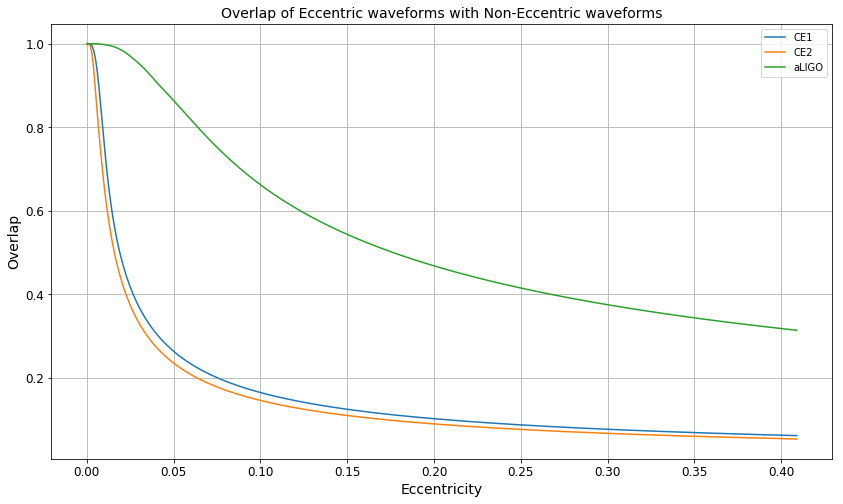

In [44]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(eccen_range, CE1_overlap, label = "CE1")
plt.plot(eccen_range, CE2_overlap, label = "CE2")
plt.plot(eccen_range, aLIGO_overlap, label = "aLIGO")
plt.legend()
plt.xlabel("Eccentricity")
plt.ylabel("Overlap")
plt.title("Overlap of Eccentric waveforms with Non-Eccentric waveforms")
plt.show()

In the above plot we can see that the overlap for Cosmic Explorer falls off much quicker than that of aLIGO. While the overlap in eccenticity for aLIGO is still $>0.8$, for Cosmic Explorer has fallen off very quickly. We see an overlap $\sim 0.2$ for eccentricities $<0.05$ This means that we can inject waveforms into the template bank with eccentricities between 0.0 and 0.05

### Injection of Eccentric Waveform into Non-eccentric Template Bank

In [ ]:
while True:
    
    #Generate random m1, m2, and ecc value within given range
    #Masses from 1.0 to 3.0--BNS
    #ecc from 0 to 0.05
    m1 = distributions.uniform.Uniform(s=(1.0, 3.0)).rvs(1)["s"] 
    m2 = distributions.uniform.Uniform(s=(1.0, 3.0)).rvs(1)["s"]
    ecc = distributions.uniform.Uniform(s=(0.0, 0.05)).rvs(1)["s"]

    #Calculate a waveform with the generated masses
    inj_plus, _ = get_fd_waveform(approximant="TaylorF2Ecc", mass1=m1,
                                              mass2=m2,
                                              delta_f=delta_f,
                                              f_lower=f_low, eccentricity=ecc)
    
    #Calculate the tau0 of the injected waveform
    inj_tau0 = conversions.tau0_from_mass1_mass2(m1, m2, f_lower=15)

    for tidx in range(len(temp_m1)):
        
        #Calculate the tau0 of the template waveform
        temp_tau0 = conversions.tau0_from_mass1_mass2(temp_m1[tidx], temp_m2[tidx], f_lower=15)
        
        #Take absolute value of difference between the 2 tau0 values
        diff_tau0 = np.abs(temp_tau0-inj_tau0)

        #Only run through loop if difference is less than 3.0
        if diff_tau0 < 3.0:
                #Calculate a waveform with template parameters
                temp_p, __ = get_fd_waveform(approximant = "TaylorF2", mass1 = temp_m1[tidx], mass2 = temp_m2[tidx],  
                                                 f_lower=f_low, delta_f=delta_f)

                flen = min(len(signal_plus), len(temp_p), len(psd_ce1))
                signal_plus.resize(flen)
                temp_p.resize(flen)

                match_ce1, _ = match(signal_plus, temp_p, psd = psd_ce1, low_frequency_cutoff = f_low)

                print m1[0], m2[0], ecc[0], temp_m1[tidx], temp_m2[tidx], match_ce1
                sys.stdout.flush() 

### Read in the Injection Match File

In [32]:
inj_match_file = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/banksim/CE1-banksim/noneccen/CE1-injections-7Hz.txt'

data = pd.read_csv(inj_match_file, sep=" ", header=None)
data.columns = ["inj_mass1", "inj_mass2", "eccentricity", "template_mass1", "template_mass2", "Overlap"]
eccentricity = data['eccentricity']
overlap = data['Overlap']

### Plot the Eccentricity vs. Fitting Factor

121286


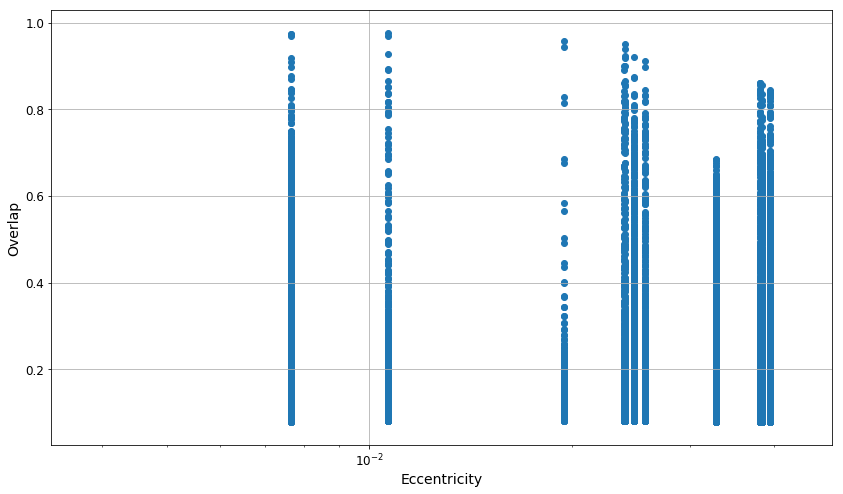

In [71]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter()
plt.xscale('log')
plt.xlabel("Eccentricity")
plt.ylabel("Overlap")
plt.show()

notes about above plot